# kNN(k-Nearest Neighbor, k近邻)练习

_完成本次作业,和输出文件,以及作业外的支持性代码,一并提交. 更多细节请参见课程网站上的[作业提交页面](http://vision.stanford.edu/teaching/cs231n/assignments.html)_

kNN 分类器包含两个阶段:

- 训练阶段: 分类器取训练数据并简单记忆
- 测试阶段: kNN 通过将每张图片和所有训练图像比较, 以及调整与之最近的k 个训样本, 来对每张图片进行分类
- 其中,需要交叉验证 k 的值

在本次练习中,你将会实现这些步骤并且理解图像分类的流程,交叉验证,尝试熟练写出高效的向量化代码.

In [1]:
# -*- coding:UTF-8 -*-

import random # 用于随机数生成
import numpy as np # 用于向量和矩阵运算
from cs231n.data_utils import load_CIFAR10 # 加载CIFAR10 图片数据集
import matplotlib.pyplot as plt # 绘图

# 设置matplotlib 绘图为内联模式,而不是在新的窗口中打开
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 设置notebook 能够自动加载其他Python模块
# 详见http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


In [2]:
# 加载CIFAR-10 原始数据
# http://www.cs.toronto.edu/~kriz/cifar.html 下载
cifar10_dir = 'cs231n\datasets\cifar-10-batches-py' 
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 作为安全检查,输出训练集和测试集的大小
print(u"训练集数据大小: ")
print( X_train.shape)
print(u"训练集标签大小：")
print(y_train.shape)
print(u"测试集数据大小：")
print(X_test.shape)
print(u"测试集标签大小：")
print(y_test.shape)

训练集数据大小: 
(50000L, 32L, 32L, 3L)
训练集标签大小：
(50000L,)
测试集数据大小：
(10000L, 32L, 32L, 3L)
测试集标签大小：
(10000L,)


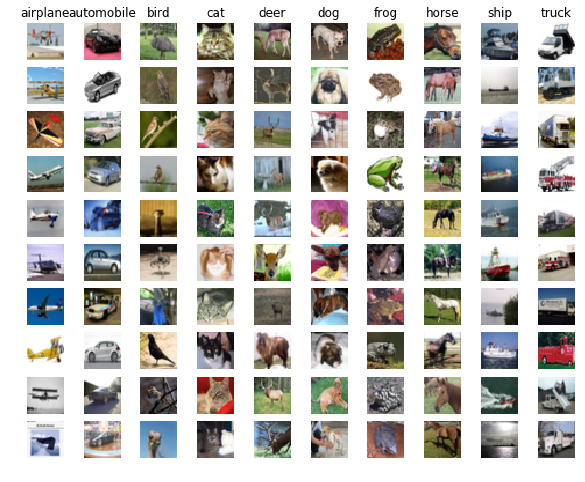

In [3]:
# 展示数据集中的一些图片例子
# 训练集中每个例子来几个
classes_hans =['飞机', '汽车', '鸟', '猫', '鹿', '狗', '蛙', '马', '船', '卡车']
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

num_classes = len(classes)
assert(len(classes_hans)==len(classes))

samples_per_class = 10

for y, cls in enumerate(classes):
#     print(y, cls)
    idxs = np.flatnonzero(y_train==y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i*num_classes+y+1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i==0:
            plt.title(cls)
plt.show()
# plt.savefig('samples.pdf')

In [4]:
# 抽取数据集的一部分进行训练和测试（加快计算）
num_training = 5000
mask = range(num_training) # mask为 0~4999 的一位列表
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# img2vec
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

((5000L, 3072L), (500L, 3072L))


In [7]:
from cs231n.classifiers import KNearestNeighbor

# 创建一个 kNN 分类器实例
# 对于 kNN 算法而言， 不需要训练的过程（训练为一个空操作noop）
# 分类器只是简单地记忆数据，并不进行进一步地操作

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

现在我们可以使用 kNN分类器来对测试集数据进行分类。回顾以下， 我们可以把整个过程分解成为以下两个步骤：

1. 首先，我们必须计算出练集中每个数据和测试集中每个数据对应的距离；
2. 然后，有了这些距离，对于每一份测试样例，找出距离其最近的k个样例，统计他们的标签，票数决定改样例所属标签

对于计算所有训练集中所有样例和测试集所有样例间的距离.例如，我们的训练样本中有**Ntr** 个样例，测试样本中有**Nte**个样例,结果应当是一个**Nte x Ntr**的矩阵,矩阵中第(i,j)位置上的值表示第i个测试样例,和第j个训练样例的距离.

首先,打开`cs231n/classifiers/k_nearest_neighbor.py`文件, 并实现其中的`compute_distances_two_loops`函数,顾名思义,使用双层循环(非常不高效)对所有的(test, train)样例对遍历, 每次计算距离矩阵中的一个元素.

In [8]:
# 打开 cs231n/classfiers/k_nearest_neighbor.py 
# 实现其中的 compute_distances_two_loops

# 测试自己的实现
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500L, 5000L)


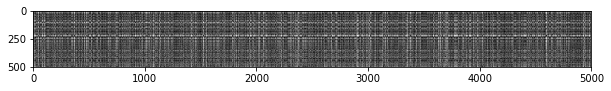

In [9]:
# 可视化距离矩阵, 其中每一行就是一个测试集样例对于训练集的距离

plt.imshow(dists, interpolation='none')
plt.show()

**相关问题 #1:**注意观察距离矩阵的结构特点, 其中有些列和行看起来要亮一些.(默认的显示设置为,距离近的颜色越深,距离远的颜色越淡).

- 明显较亮的行,反映了数据中哪些特点?
- 明显较亮的列,反映了数据中哪些特点?

**我的回答:** -如果第 i 个测试数据和训练集数据中的很多都很相似,那么第 i 行应该颜色较暗.反之,第 i 行较亮. -如果第 j 个训练数据和测试数据总的很多都很相似,那么这一列的颜色就会比较暗, 反之就较亮.

In [11]:
# 实现函数 predict_labels 然后运行下方代码:
# 我们令 k =1 (表示最近邻居)
y_test_pred = classifier.predict_labels(dists, k=1)

# 计算和输出预测正确的比例
num_correct = np.sum(y_test_pred==y_test)
accuracy = float(num_correct)/num_test
print(u"Got %d / %d correct => accuracy: %f"%(num_correct, num_test, accuracy))


Got 137 / 500 correct => accuracy: 0.274000


In [43]:
# 现在,我们使用局部向量化的方法来加速距离矩阵的运算,只使用一次循环
# 实现函数, compute_distances_one_loop 然后运行以下代码

dists_one = classifier.compute_distances_one_loop(X_test)
# 为了确保我们的向量化实现是正确的,我们必须保证其效果和原始的实现结果一致
# 有好几种判断两种实现的距离矩阵是否相同的方法: 一种最简单的方法是 Frobenius
# 范数,为了避免你从来没听说过它,特说明, Frobenius 范数就是两个矩阵,对应值
# 差值平方和的平方根,换句话说就是把两个矩阵转换为向量, 然后计算他们的欧氏距离

difference  = np.linalg.norm(dists - dists_one, ord='fro')
print("Difference was: %f"%(difference,))
if difference <0.001:
    print('Good! The distance matrixs are the same!')
else:
    print('Uh-oh! The distance matrixs are different!')


Difference was: 0.000000
Good! The distance matrixs are the same!


In [46]:
# 我们实现全向量化的版本, compute_disntances_no_loops 运行下方代码
dists_two = classifier.compute_distances_no_loops(X_test)

# 检查计算出的结果和原来的计算结果是否一致

difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f'%(difference,))
if difference < 0.0001:
    print('Good! The distances are the same!')
else:
    print('Uh-oh! The distance are different! ')
    

Difference was: 0.000000
Good! The distances are the same!


In [12]:
# 计算这几种实现分别耗时为多少
def time_function(f, *args):
    """
    参数:
    f -- 调用函数 f
    args -- 函数 f 的参数
    
    返回:
    函数执行的时间
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc- tic

In [14]:
two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print(u'双重循环版本耗时:')
print(two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print(u"单重循环版本耗时:")
print(one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print(u"无循环版本耗时:")
print(no_loop_time)

双重循环版本耗时:
78.1679999828
单重循环版本耗时:
99.998000145
无循环版本耗时:
0.742999792099


### 交叉验证(Cross-validation)

我们已经实现了 kNN 分类器,随便设置了 k 的值. 现在我们需要通过交叉验证来确定最佳的 k 值(超参数).

In [16]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# 待完善
# 将训练数据拆分成一个个折. 拆分后, X_train_folds,  y_train_flods 均为
# 长度为 num_flods 的 list. 其中 y_train_folds[i]  是 X_train_folds[i]
# 的标签组成的向量. 
# 提示: 也许会使用到 array_split 函数
################################################################################
# 通过
y_train_ = y_train.reshape(-1, 1)
X_train_folds , y_train_folds = np.array_split(X_train, 5), np.array_split(y_train_, 5)
################################################################################
#                                 代码结束                            #
################################################################################

# 我们使用一个字典, 当运行交叉验证时, 存储使用不同k 值导致的精确度.
# 运行完交叉验证之后, k_to_accuracies[k] 为一个列表, 大小为 num_folds
# 其中存储的时我们使用不同的 k 值对应的精确度

k_to_accuracies = {}

################################################################################
# 待完善:
# 采用不同的 k折 交叉验证来找出最合适的k.
# 对于每个可能的 k, 对其运行 num_folds 次 kNN 算法,
# 每次运行,挑选其中一个fold 作为验证集,其余的作为训练数据
#  Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary. 
################################################################################
for k_ in k_choices:
    k_to_accuracies.setdefault(k_, [])
for i in range(num_folds):
    classifier = KNearestNeighbor()
    X_val_train = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
    y_val_train = np.vstack(y_train_folds[0:i] + y_train_folds[i+1:])
    y_val_train = y_val_train[:,0]
    classifier.train(X_val_train, y_val_train)
    for k_ in k_choices:
        y_val_pred = classifier.predict(X_train_folds[i], k=k_)
        num_correct = np.sum(y_val_pred == y_train_folds[i][:,0])
        accuracy = float(num_correct) / len(y_val_pred)
        k_to_accuracies[k_] = k_to_accuracies[k_] + [accuracy]
################################################################################
#                                 代码结束                            #
################################################################################        

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

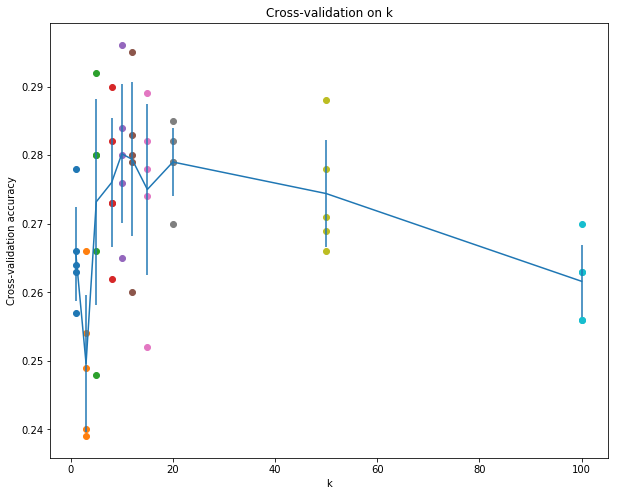

In [20]:
# 绘图输出观测结果
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k]*len(accuracies), accuracies)
    
# 绘图趋势线, 带误差线, 与标准差相对应
accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k, v in sorted(k_to_accuracies.items())])

plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [22]:
# 根据上方交叉验证的结果,选择最合适的 k
# 使用所有的训练数据,宠幸训练分类器,在测试集上测试
best_k = 10
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

#计算和输出在测试集上测试的精确度
num_correst = np.sum(y_test_pred==y_test)
accuracy = float(num_correct)/num_test
print('Got %d / %d correst => accuracy: %f'%(num_correct, num_test, accuracy))


Got 263 / 500 correst => accuracy: 0.526000
